# Z-Test for Proportions
> Use Case
- Used when comparing proportions of two independent groups and the sample size is sufficiently large (usually n > 30).
- Groups can have different sample sizes.
> Assumptions
- Assumes that the population follows a binomial distribution or that the sample size is large enough for the Central Limit Theorem to apply so the population resemebles the normal distribution.
- Random sampling of data points.
> Example Scenario
- Investigating whether the proportion of users who make a purchase is different between two groups (Group A and Group B) with large sample sizes.
> Null Hypothesis (H0):
- The proportion of users making a purchase is the same in Group A as in Group B.
> Alternative Hypothesis (H1):
- The proportion of users making a purchase is different between Group A and Group B.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install scipy==1.12.0
from scipy.stats import norm

# !pip install statsmodels==0.12.2
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize

/Users/sam/opt/anaconda3/envs/ab_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/sam/opt/anaconda3/envs/ab_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/var/folders/r4/fdchq33x2vg7z1_7dstrhrn80000gn/T/ipykernel_17353/2526623642.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/544

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# set seaborn style
sns.set(style="white", palette="mako")

# colors
color = 'cornflowerblue'

# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### Power Analysis

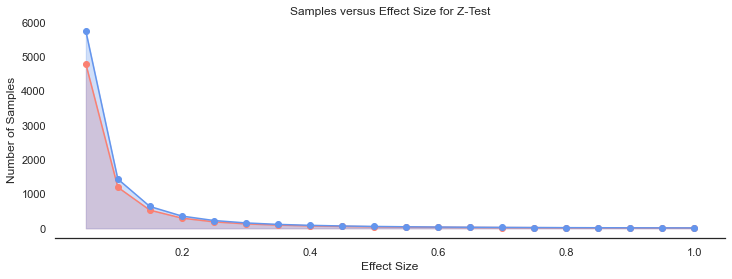

In [4]:
# Create a NormalIndPower instance
power_analysis = NormalIndPower()

# Define effect sizes
effect_sizes = np.linspace(0.05, 1, 20) 

# Estimated Ratio of sample sizes (smaller/larger), 1.0 for equal samples per group
ratio = 1.2
# Significance level
alpha = 0.05  
# Desired statistical power
power = 0.8  

# Calculate number of samples for each effect size
samples = [power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=ratio, alternative='two-sided') for effect_size in effect_sizes]

# Calculate the required sample size for the smaller group
samples_small = [s / ratio for s in samples]


# Figure size
plt.figure(figsize=(12, 4))

# Plot samples versus effect sizes
plt.plot(effect_sizes, samples_small, color='salmon', marker='o')
# Shade area below the line with lower opacity
plt.fill_between(effect_sizes, samples_small, color='salmon', alpha=0.3)

# Plot samples versus effect sizes
plt.plot(effect_sizes, samples, color=color, marker='o')
# Shade area below the line with lower opacity
plt.fill_between(effect_sizes, samples, color=color, alpha=0.3)


# Add plot labels and title
plt.xlabel('Effect Size')
plt.ylabel('Number of Samples')
plt.title('Samples versus Effect Size for Z-Test')
plt.show()

In [5]:
# Create a NormalIndPower instance
power_analysis = NormalIndPower()

# Desired effect size
effect_size = 0.05

# Estimated Ratio of sample sizes (smaller/larger), 1.0 for equal samples per group
ratio = 1.2
# Significance level
alpha = 0.05  
# Desired statistical power
power = 0.8  

# Calculate the required sample size for the larger group
sample_size_large = int(power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=ratio, alternative='two-sided'))

# Calculate the required sample size for the smaller group
sample_size_small = int(sample_size_large / ratio)

# Print the results
print(f"Required sample size for the larger group: {sample_size_large}")
print(f"Required sample size for the smaller group: {sample_size_small}")

Required sample size for the larger group: 5755
Required sample size for the smaller group: 4795


### Synthetic Data

In [6]:
# Number of samples for each group
n_samples_group_A = sample_size_large
n_samples_group_B = sample_size_small

# Generate synthetic data for two groups
group_A_purchases = np.random.binomial(n=1, p=0.2, size=n_samples_group_A)
group_B_purchases = np.random.binomial(n=1, p=0.25, size=n_samples_group_B)

# Ensure the lists are of the same size
max_len = max(len(group_A_purchases), len(group_B_purchases))
group_A_purchases = np.append(group_A_purchases, [np.nan] * (max_len - len(group_A_purchases)))
group_B_purchases = np.append(group_B_purchases, [np.nan] * (max_len - len(group_B_purchases)))

# Create pandas data frame
z_test_data = pd.DataFrame({'Group_A_Purchases': group_A_purchases, 'Group_B_Purchases': group_B_purchases})
z_test_data = z_test_data.astype("Int64")
z_test_data


,Group_A_Purchases,Group_B_Purchases
0,0,0
1,1,0
2,0,0
3,0,0
4,0,0
...,...,...
5750,0,<NA>
5751,0,<NA>
5752,0,<NA>
5753,0,<NA>


### Check Assumptions

In [7]:
# Assumption check for z-test for proportions
successes_group_A = z_test_data['Group_A_Purchases'].sum()
failures_group_A = n_samples_group_A - successes_group_A
successes_group_B = z_test_data['Group_B_Purchases'].sum()
failures_group_B = n_samples_group_B - successes_group_B

min_sample_size = 30

# Check if successes and failures are sufficiently large
z_test_assumption_met = all(n > min_sample_size for n in [successes_group_A, failures_group_A, successes_group_B, failures_group_B])

# Check if the data is binary
binary_A_check = (z_test_data['Group_A_Purchases'].isin([0, 1, np.nan, pd.NA]).all())
binary_B_check = (z_test_data['Group_B_Purchases'].isin([0, 1, np.nan, pd.NA]).all())

print(f"Z-Test for Proportions Assumption: Successes and failures are sufficiently large - {'Met' if z_test_assumption_met else 'Not Met'}")
print(f"Binomial Test Assumption: Data is numeric and binary - {'Met' if binary_A_check and binary_B_check else 'Not Met'}")


Z-Test for Proportions Assumption: Successes and failures are sufficiently large - Met
Binomial Test Assumption: Data is numeric and binary - Met


### Z-Test (statsmodels)

In [8]:
# Pre-determined alpha
alpha = 0.05  

In [9]:
# Z-test for proportions
count = np.array([successes_group_A, successes_group_B])
nobs = np.array([n_samples_group_A, n_samples_group_B])

z_stat, p_value_z = proportions_ztest(count, nobs)

print(f"Z-Test Statistic: {z_stat}")
print(f"\nP-value for Z-Test: {p_value_z}")

# Check for statistical significance
if p_value_z < alpha:
    conclusion = "Reject the null hypothesis."
    interpretation = "There is a significant difference in the proportions between Group A and Group B."
else:
    conclusion = "Fail to reject the null hypothesis."
    interpretation = "There is no significant difference in proportions between Group A and Group B."
print("\n")
print(conclusion)
print(interpretation)


Z-Test Statistic: -4.693243551748401

P-value for Z-Test: 2.6890702730781386e-06


Reject the null hypothesis.
There is a significant difference in the proportions between Group A and Group B.


### 95% Confidence Interval

In [10]:
# For 95% confidence interval
confidence_level = 0.95

# Calculate the difference in proportions
prop1 = successes_group_A / n_samples_group_A
prop2 = successes_group_B / n_samples_group_B

diff_prop = prop1 - prop2

# Calculate the standard error for the difference in proportions
se_diff = np.sqrt(prop1 * (1 - prop1) / n_samples_group_A + prop2 * (1 - prop2) / n_samples_group_B)

# Calculate the margin of error
margin_of_error = norm.ppf(1 - (1 - confidence_level) / 2) * se_diff  

# Calculate the confidence interval for the difference in proportions
lower_bound = diff_prop - margin_of_error
upper_bound = diff_prop + margin_of_error

# Print results
print(f"Difference in Proportions: {diff_prop}")
print(f"{round(confidence_level*100)}% Confidence Interval for Difference in Proportions: [{lower_bound}, {upper_bound}]")

Difference in Proportions: -0.03778226124266065
95% Confidence Interval for Difference in Proportions: [-0.05363425240280412, -0.02193027008251719]


### Effect Size

In [11]:
# Cohen's h effect size
h = proportion_effectsize(prop1, prop2, method='normal')
# h = np.abs((2*np.arcsin(np.sqrt(prop1))) - (2*np.arcsin(np.sqrt(prop2))))

print(f"Cohen's h Effect Size: {h}")
print("\n")

if h == 0:
    print("There is no difference between the two groups.")
elif h <= 0.2:
    print("There is a small difference between the two groups.")
elif h <= 0.5:
    print("There is a moderate difference between the two groups.")
elif h <= 0.8:
    print("There is a large difference between the two groups.")
else:
    print("There is a very large difference between the two groups.")

Cohen's h Effect Size: -0.09158088012238719


There is a small difference between the two groups.


### Odds Ratio

In [16]:

# Odds Ratio
odd_ratio =  (successes_group_B * failures_group_A) / (successes_group_A * failures_group_B) 

print(f"The odds ratio is {round(odd_ratio, 4)}")
print(f"The odds of the outcome are {round(odd_ratio, 4)} times as high in the exposed group compared to the unexposed group.")
print("\n")

if odd_ratio > 1:
    print("This suggests a positive association between the exposure and the outcome.\nIt means that the odds of the outcome occurring in the exposed group are higher than the odds of the outcome occurring in the unexposed group. ")
elif odd_ratio < 1:
    print("This implies a negative association between the exposure and the outcome.\nIt indicates that the odds of the outcome occurring in the exposed group are lower than the odds of the outcome occurring in the unexposed group.")
else:
    print("This indicates no association between the exposure and the outcome.\nIn other words, the odds of the outcome occurring in the exposed group are the same as the odds of the outcome occurring in the unexposed group.")

The odds ratio is 1.2486
The odds of the outcome are 1.2486 times as high in the exposed group compared to the unexposed group.


This suggests a positive association between the exposure and the outcome.
It means that the odds of the outcome occurring in the exposed group are higher than the odds of the outcome occurring in the unexposed group. 


### Summary Table

In [13]:
# Count everything up
total_count = z_test_data.size
group_a_count = z_test_data['Group_A_Purchases'].count()
group_b_count = z_test_data['Group_B_Purchases'].count()
group_a_positive_count = z_test_data['Group_A_Purchases'].value_counts()[1]
group_a_negative_count = z_test_data['Group_A_Purchases'].value_counts()[0]
group_b_positive_count = z_test_data['Group_B_Purchases'].value_counts()[1]
group_b_negative_count = z_test_data['Group_B_Purchases'].value_counts()[0]

In [14]:
# Create a new DataFrame for plotting
plot_data = pd.DataFrame({
    'Test Group': ["Group A", "Group B"],
    'Total': [group_a_count, group_b_count],
    'Purchase': [group_a_positive_count, group_b_positive_count],
    'No Purchase': [group_a_negative_count, group_b_negative_count],
    'Purchase Rate': [group_a_positive_count/group_a_count, group_b_positive_count/group_b_count],
}, index=[0, 1])
plot_data

,Test Group,Total,Purchase,No Purchase,Purchase Rate
0,Group A,5755,1146,4609,0.199131
1,Group B,4795,1136,3659,0.236913


### Visualization

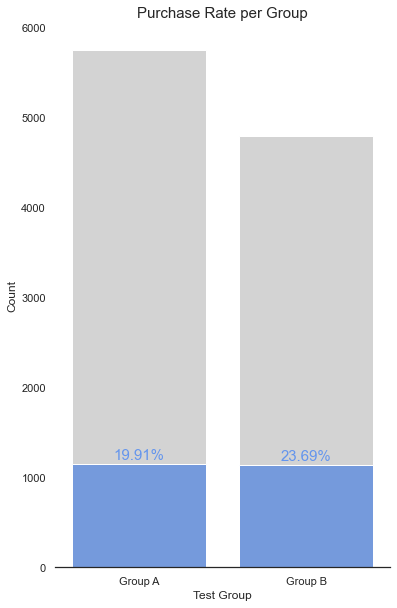

In [17]:
# Plot stacked bars
plt.figure(figsize=(6, 10))

plot_total = sns.barplot(x=plot_data['Test Group'], 
                        y=plot_data['Total'], color='lightgrey')

plot_satisfied = sns.barplot(x=plot_data['Test Group'], 
                            y=plot_data['Purchase'], color=color)

# Set labels and title
plt.title('Purchase Rate per Group', fontsize=15)
plt.ylabel('Count')
plt.tick_params(left=False,bottom=False,labelleft=True,labelbottom=True)

# Put values on top of bars
row_list = []
for index, row in plot_data[plot_data['Test Group'] == 'Group A'][['Purchase', 'Purchase Rate']].iterrows():
    plot_total.text(row.name, row['Purchase']+50, str(round(100 * row['Purchase Rate'], 2)) + '%', color=color, ha="center", fontsize=15)
for index, row in plot_data[plot_data['Test Group'] == 'Group B'][['Purchase', 'Purchase Rate']].iterrows():
    plot_satisfied.text(row.name, row['Purchase']+50, str(round(100 * row['Purchase Rate'], 2)) + '%', color=color, ha="center", fontsize=15)


# Show the plot
plt.show()